In [1]:
from fastai.vision.all import *
import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import cv2

In [2]:
path = Path('/home/azaidi/Desktop/kaggle/seti')
Path.BASE_PATH = path
path.ls()

(#6) [Path('data'),Path('models'),Path('initial.ipynb'),Path('seti-breakthrough-listen.zip'),Path('.ipynb_checkpoints'),Path('data_extract.ipynb')]

In [3]:
(path/'data/train').ls()

(#17) [Path('data/train/9'),Path('data/train/e'),Path('data/train/3'),Path('data/train/5'),Path('data/train/7'),Path('data/train/d'),Path('data/train/b'),Path('data/train/1'),Path('data/train/a'),Path('data/train/0')...]

In [4]:
(path/'data/train').ls()[0].ls()

(#3139) [Path('data/train/9/9f0dff2cd2b3.npy'),Path('data/train/9/91af44908241.npy'),Path('data/train/9/923ed9e2e4d8.npy'),Path('data/train/9/990f15496627.npy'),Path('data/train/9/92a91b53e5ee.npy'),Path('data/train/9/9567d242de97.npy'),Path('data/train/9/9f5cb9d7a0d6.npy'),Path('data/train/9/9aea15089923.npy'),Path('data/train/9/9deb1a9a72a5.npy'),Path('data/train/9/9e26f4ef6fc6.npy')...]

In [5]:
train_df = pd.read_csv(path/'data/train_labels.csv')
sub_df = pd.read_csv(path/'data/sample_submission.csv')

In [6]:
train_df.head(2)

,id,target
0,00034abb3629,0
1,0004300a0b9b,0


In [7]:
sub_df.head(1)

,id,target
0,00034db451c4,0.5


In [8]:
data_path = path/'data'

In [9]:
train_df['path'] = train_df['id'].apply(lambda x: str(data_path/'train'/x[0]/x)+'.npy')

In [10]:
train_df.tail(3)

,id,target,path
50162,fffaf1658eb7,0,/home/azaidi/Desktop/kaggle/seti/data/train/f/fffaf1658eb7.npy
50163,fffb0fc8c613,0,/home/azaidi/Desktop/kaggle/seti/data/train/f/fffb0fc8c613.npy
50164,fffd1cad9995,0,/home/azaidi/Desktop/kaggle/seti/data/train/f/fffd1cad9995.npy


In [16]:
class SETIDataset:
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        label = self.df.iloc[index].target
        filename = self.df.iloc[index].path
        data = np.load(filename).astype(np.float32)
        #image = image.astype(np.float32)
        #image = np.vstack(image).transpose((1, 0))
        data = np.vstack(data).transpose((1, 0))
        data = cv2.resize(data, dsize=(256,256))     
        data_tensor = torch.tensor(data).float().unsqueeze(0)

        return (data_tensor, torch.tensor(label))

In [17]:
t_df, v_df = train_test_split(train_df, test_size=0.2)

In [18]:
t_df.shape, v_df.shape

((40132, 3), (10033, 3))

In [19]:
t_ds = SETIDataset(t_df)
v_ds = SETIDataset(v_df)

In [20]:
t_ds[0][0].shape

torch.Size([1, 256, 256])

In [21]:
#sample = np.load(train_df.path[0])
#sample.shape

In [22]:
#np.vstack(sample).shape, np.vstack(sample).transpose((1,0)).shape

In [23]:
bs = 128
train_dl = torch.utils.data.DataLoader(t_ds, batch_size=bs,num_workers=8)
valid_dl = torch.utils.data.DataLoader(v_ds, batch_size=bs,num_workers=8)

In [24]:
len(train_dl), len(valid_dl)

(314, 79)

In [25]:
dls = DataLoaders(train_dl, valid_dl)

In [26]:
#batch = next(iter(dls.train))

In [27]:
#batch[0].shape

In [28]:
def roc_auc(preds,targ):
    try: return roc_auc_score(targ.cpu(),preds.squeeze().cpu())
    except: return 0.5

In [29]:
from timm import create_model
from fastai.vision.learner import _update_first_layer

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
        
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children()))
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model.to('cuda')

def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_in=3, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, n_in=n_in, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [33]:
learn = timm_learner(dls,'resnext50_32x4d',pretrained=True,
                     n_in=1,n_out=1,metrics=[roc_auc], 
                     loss_func=BCEWithLogitsLossFlat()).to_fp16()

In [32]:
#bs 128
learn.fit_one_cycle(3, 3e-2, wd=0.1, cbs=[ReduceLROnPlateau()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.128324,0.106726,0.951956,01:47
1,0.085036,0.066610,0.969518,01:43
2,0.055569,0.063772,0.972989,01:43


In [34]:
#w/bs of 128
learn.fit_one_cycle(4, 3e-2, wd=0.1, cbs=[ReduceLROnPlateau()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.145937,0.102893,0.945189,01:43
1,0.095226,0.080616,0.963928,01:44
2,0.070886,0.064321,0.973500,01:44
3,0.046705,0.058909,0.978021,01:44


In [37]:
learn = learn.to_fp32()

In [38]:
learn.save('testing')

Path('models/testing.pth')

In [61]:
learn = timm_learner(dls,'efficientnet_b3',pretrained=True,
                     n_in=1,n_out=1,metrics=[roc_auc], 
                     loss_func=BCEWithLogitsLossFlat()).to_fp16()

In [54]:
#w/bs of 32
learn.fit_one_cycle(10, 3e-2, wd=0.1, cbs=[ReduceLROnPlateau(), GradientClip()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.197946,0.156366,0.917560,01:31
1,0.113092,0.104877,0.952699,01:31
2,0.091607,0.100150,0.967157,01:31
3,0.079830,0.081048,0.966055,01:31
4,0.070917,0.072906,0.974007,01:31
5,0.058037,0.069038,0.972385,01:31
6,0.044414,0.065638,0.973788,01:31
7,0.030355,0.070646,0.973413,01:31
8,0.015235,0.089501,0.967101,01:31
9,0.007843,0.100488,0.964944,01:31


Epoch 7: reducing lr to 0.0004978169755764046
Epoch 8: reducing lr to 0.00013052570328421568
Epoch 9: reducing lr to 3.133464151934551e-08


SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.0691830962896347)

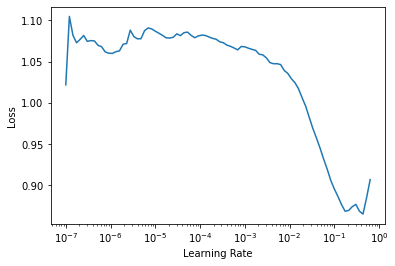

In [56]:
learn.lr_find()

In [62]:
#w/bs of 8
learn.fit_one_cycle(5, 5e-2, wd=0.1, cbs=[ReduceLROnPlateau(), GradientClip()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.149340,0.112057,0.952511,01:31
1,0.109781,0.092013,0.961260,01:31
2,0.087825,0.113101,0.969974,01:31
3,0.057585,0.059366,0.976141,01:31
4,0.040495,0.053791,0.979075,01:31


Epoch 2: reducing lr to 0.0027679764219979827


In [ ]:
learn = learn.to_fp32()
learn.save('eff3')